In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, rdMolTransforms
import os
import fnmatch
import numpy as np
import deepchem as dc
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GMM
import random
from tflearn.activations import leaky_relu
from deepchem.utils.rdkit_util import get_xyz_from_mol
from deepchem.feat.rdkit_grid_featurizer import convert_atom_to_voxel, compute_centroid, rotate_molecules

In [3]:
from deepchem.feat.graph_features import ConvMolFeaturizer
from deepchem.feat.adjacency_fingerprints import AdjacencyFingerprint

In [4]:
def featurize_mols(mol_files, max_n_atoms):
    featurizer = AdjacencyFingerprint(max_n_atoms=max_n_atoms)
    features = []
    for idx, mol_file in enumerate(mol_files):
        if idx % 32 == 0:
            print(idx)
        try:
            bond_dist_mat = np.zeros((max_n_atoms, max_n_atoms))
            
            mol = Chem.MolFromMol2File(mol_file)
            mol_xyz = get_xyz_from_mol(mol)
            centroid = compute_centroid(mol_xyz)
            mol_xyz -= centroid
            temp = np.zeros((max_n_atoms, 3))
            temp[:mol_xyz.shape[0]] = mol_xyz
            mol_xyz = temp
            
            #mol_xyz = rotate_molecules([mol_xyz])[0]

            c = mol.GetConformer(0)
            
            for bond in mol.GetBonds():
                atom_i, atom_j = (bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx())
                bond_dist_mat[atom_i, atom_j] = rdMolTransforms.GetBondLength(c, atom_i, atom_j)
                bond_dist_mat[atom_j, atom_i] = rdMolTransforms.GetBondLength(c, atom_i, atom_j)

            if mol is None:
                features.append(None)
                continue
                
            graph_feat = featurizer.featurize([mol])[0]
            
            features.append((mol_file, bond_dist_mat, mol_xyz, graph_feat))
        except:
            features.append(None)
    return(features)

In [5]:
import pickle
max_n_atoms = 25
S = 64
feature_file = "./voxel_features_pdbbind.pkl"
#if not os.path.exists(feature_file):
if 1== 1:
    pdbbind_dir = "/home/evan/Documents/deep_docking/datasets/v2015/"
    def find_files(directory, pattern):
        for root, dirs, files in os.walk(directory):
            for basename in files:
                if fnmatch.fnmatch(basename, pattern):
                    filename = os.path.join(root, basename)
                    yield filename
    ligand_files = []
    for f in find_files(pdbbind_dir, "*ligand.mol2"):
        ligand_files += [f]
    ligand_files = ligand_files[:300]
    features = featurize_mols(ligand_files, max_n_atoms)
    with open(feature_file, "wb") as f:
        pickle.dump(features, f, protocol=2)
else:
    with open(feature_file, "rb") as f:
        features = pickle.load(f)

0
32
64
96
128
160
192
224
256
288


In [6]:
features = [f for f in features if f is not None]

In [7]:
len(features)

121

In [8]:
features[0]

('/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2',
 array([[ 0.        ,  1.43459297,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 1.43459297,  0.        ,  1.42808228,  1.60942661,  0.        ,
          0.        ,  0.        ,  1.77253858,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  1.42808228,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        , 

In [9]:
features[0][1].shape

(25, 25)

In [10]:
import tensorflow as tf
tf.reset_default_graph()
alpha = 0.01
n_layers = 2

S = 32

B = max_n_atoms
p = 75

z_dim = 128

L_list = [p, 64, 64, 128, 256]


n_bonds = 50
dihed_per_bond = 1
valence = 4



In [11]:
with tf.device('/gpu:0'):
    x = tf.placeholder(tf.float32, [S, B, L_list[0]], name="atom_features")
    keep_prob = tf.constant(1.)
    
    adj_matrix = tf.placeholder(tf.float32, shape=[S, B, B], name="adj_matrix")
    
    #dist_matrix2d = tf.placeholder(tf.float32, shape=[S, B, B], name="dist_matrix2d")
    bond_dist_mat = tf.placeholder(tf.float32, shape=[S, B, B], name="bond_dist_mat")
    
    mol_xyz = tf.placeholder(tf.float32, shape=[S, B, 3], name="molxyz")
    
    z = tf.random_normal([S, B, z_dim], mean=0, stddev=1)


In [12]:
#adapted from: http://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
def compute_distance_matrix(A):
    r = tf.reduce_sum(A*A, 1) # turn r into column vector 
    r = tf.reshape(r, [-1, 1]) 
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return(D)

In [13]:
GW_list = [None for i in range(n_layers)]
Gb_list = [None for i in range(n_layers)]

DW_list = [None for i in range(n_layers)]
Db_list = [None for i in range(n_layers)]


Gh_list = [x]
Dh_list = [x]

adj_list = [adj_matrix]
B_list = [B]
clades_list = []
graph_stride = 1.

print("building clades and adj")
for i in range(n_layers):
    print(i)
    B_list.append(int(np.ceil(B_list[i]/graph_stride)))
    print(B_list)
    clades_list.append(tf.stack([tf.one_hot(range(0,B_list[i],int(graph_stride)), depth=B_list[i])]*S, axis=0)) 


    adj_temp = tf.matmul(clades_list[i], adj_list[i])
    sub_adj = tf.matmul(adj_temp, tf.transpose(adj_temp, perm=[0, 2, 1]))
    sub_adj = tf.minimum(sub_adj, 1.)
    adj_list.append(sub_adj)

print("Building hidden layers")
for layer_idx in range(n_layers):
    GW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="GW_list%d" %layer_idx)
    Gb_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))
    
    DW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="DW_list%d" %layer_idx)
    Db_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))
    
g_w1_ini = tf.Variable(tf.truncated_normal([1, L_list[n_layers]+z_dim, 64]))
g_w1 = tf.tile(g_w1_ini, [S, 1, 1])

g_b1 = tf.Variable(tf.ones([1, 1, 64]))

g_w2_ini = tf.Variable(tf.truncated_normal([1, 64, 3]))
g_w2 = tf.tile(g_w2_ini, [S, 1, 1])
g_b2 = tf.Variable(tf.ones([1, 1, 3]))

d_w1_ini = tf.Variable(tf.truncated_normal([1, B*(L_list[n_layers]*2+1), 32]))
d_w1 = tf.tile(d_w1_ini, [S, 1, 1])
d_b1 = tf.Variable(tf.ones([1, 1, 32]))

d_w2_ini = tf.Variable(tf.truncated_normal([1, 32, 1]))
d_w2 = tf.tile(d_w2_ini, [S, 1, 1])
d_b2 = tf.Variable(tf.ones([1, 1, 1]))

lam1 = tf.constant(0.01)

building clades and adj
0
[25, 25]
1
[25, 25, 25]
Building hidden layers


In [14]:
def adjacency_conv_layer(x, W, b, adj, clades, L_in, L_out, layer_idx, S, B):
    with tf.device('/gpu:0'):
        print("layer_idx: %d" %(layer_idx))
        h = tf.matmul(adj, x, name="adj_mult_%d" %layer_idx)
        h = tf.reshape(h, shape=(S*B, L_in), name="adj_reshape_1_%d" %layer_idx)

        h = tf.matmul(h, W, name="adjconv_%d" %layer_idx) + b
    
        h = tf.nn.tanh(h)
        h = tf.reshape(h, (S, B, L_out), name="adj_reshape_2_%d" %layer_idx)  

        h = tf.matmul(clades, h)

        print("within func h:")
        print(h)                                                                                                                              

    return(h)

In [15]:
#t = sess.run(tf.matmul(dihed_indices[:,:,:,0], x))
#t = np.reshape(t, [t.shape[0]*t.shape[1],t.shape[2]])

In [16]:
def generator(W_list, b_list, h_list, L_list, n_layers):
    for layer_idx in range(n_layers):
        h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                                     b_list[layer_idx], adj_list[layer_idx], 
                                                     clades_list[layer_idx],
                                                     L_list[layer_idx], L_list[layer_idx+1],
                                                     layer_idx, S, B_list[layer_idx]), keep_prob))
    L_final = L_list[n_layers]  
    
    print("h_list[-1]")
    print(h_list[-1])
    
    print("B_list")
    print(B_list)
    
    
    h_final = tf.concat([h_list[-1], z], axis=2)
    
    print("h afterz")
    print(h_final)
    
    g_h1 = tf.nn.tanh(tf.matmul(h_final, g_w1) + g_b1)
    print("g_h1")
    print(g_h1)
    g_h2 = tf.matmul(g_h1, g_w2) + g_b2
    return(g_h2)



In [17]:
def discriminator(W_list, b_list, h_list, L_list, n_layers, mols):
    with tf.device('/gpu:0'):
        for layer_idx in range(n_layers):
            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                             b_list[layer_idx], adj_list[layer_idx], 
                                             clades_list[layer_idx],
                                             L_list[layer_idx], L_list[layer_idx+1],
                                             layer_idx, S, B_list[layer_idx]), keep_prob))
        h_final = h_list[-1]
        dist_matrix = tf.stack([compute_distance_matrix(tf.reshape(mol, [B, 3])) for mol in tf.split(mols, S, axis=0)], axis=0)
        #dist_matrix = compute_distance_matrix(mol)
        bond_dist_gen = tf.multiply(dist_matrix, adj_matrix)
        wrong_bond_loss = tf.multiply(tf.reduce_sum(tf.square(tf.subtract(bond_dist_mat, bond_dist_gen)), axis=[1,2]), lam1)
       
        feat_i = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_i = tf.tile(feat_i, [1, 1, B, 1])
        
        feat_j = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_j = tf.transpose(feat_j, perm=[0, 2, 1, 3])
        feat_j = tf.tile(feat_j, [1, B, 1, 1])
        
        d_h1 = tf.concat([tf.reshape(dist_matrix, [S, B, B, 1]), feat_i, feat_j], axis=3)
        d_h1 = tf.reshape(d_h1, [S, B, B*(L_list[n_layers]*2+1)])
        d_h2 = leaky_relu(tf.matmul(d_h1, d_w1) + d_b1)
        d_h2 = tf.matmul(d_h2, d_w2) + d_b2
        
    
    return(d_h2, bond_dist_gen)

In [18]:

theta_D = DW_list[:n_layers] + Db_list[:n_layers] + [d_w1_ini, d_b1, d_w2_ini, d_b2]

theta_G =  DW_list[:n_layers] + Db_list[:n_layers] + [g_w1_ini, g_b1, g_w2_ini, g_b2]

In [19]:
import time 

with tf.device('/gpu:0'):    

    G_sample = generator(DW_list, Db_list, Dh_list, L_list, n_layers)

    D_real, bond_dist_real = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, mol_xyz)
    D_fake, bond_dist_fake = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, G_sample)


    D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
    G_loss = -tf.reduce_mean(D_fake)
    clip_D = []
    for p in theta_D:
        print(p)
        p.assign(tf.clip_by_value(p, -0.01, 0.01))
    #clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in theta_D]
    #clip_types = types1.assign(tf.clip_by_value(types1, -0.1, 0.1))

    #D_solver = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(D_loss, var_list=theta_D)
    #G_solver = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(G_loss, var_list=theta_G)

    D_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-3)
                .minimize(-D_loss, var_list=theta_D))
    G_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-3)
                .minimize(G_loss, var_list=theta_G))

mb_size = S

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())


preds = []

d_losses = []
g_losses = []
#print(sess.run(label_placeholder))


    

layer_idx: 0
within func h:
Tensor("MatMul_4:0", shape=(32, 25, 64), dtype=float32, device=/device:GPU:0)
layer_idx: 1
within func h:
Tensor("MatMul_5:0", shape=(32, 25, 64), dtype=float32, device=/device:GPU:0)
h_list[-1]
Tensor("MatMul_5:0", shape=(32, 25, 64), dtype=float32, device=/device:GPU:0)
B_list
[25, 25, 25]
h afterz
Tensor("concat:0", shape=(32, 25, 192), dtype=float32, device=/device:GPU:0)
g_h1
Tensor("Tanh_2:0", shape=(32, 25, 64), dtype=float32, device=/device:GPU:0)
layer_idx: 0
within func h:
Tensor("MatMul_8:0", shape=(32, 25, 64), dtype=float32, device=/device:GPU:0)
layer_idx: 1
within func h:
Tensor("MatMul_9:0", shape=(32, 25, 64), dtype=float32, device=/device:GPU:0)
layer_idx: 0
within func h:
Tensor("MatMul_44:0", shape=(32, 25, 64), dtype=float32, device=/device:GPU:0)
layer_idx: 1
within func h:
Tensor("MatMul_45:0", shape=(32, 25, 64), dtype=float32, device=/device:GPU:0)
Tensor("DW_list0/read:0", shape=(75, 64), dtype=float32)
Tensor("DW_list1/read:0", sha

In [20]:
def construct_feed_dict(X, start=None,
                      stop=None, y=None,
                      keep_prob=1.0, train=True,
                       shuffle_inds=True):
    a = time.time()
    if start is None:
      start = 0
      stop = len(X)
    
    inds = range(start, stop)
    if shuffle_inds:
        random.shuffle(inds)

    atom_adj_batch = [X[idx][3][0] for idx in inds]
    A_batch = np.array([X[idx][3][1] for idx in inds])
    bond_dist_batch = [X[idx][1] for idx in inds]
    mol_xyz_batch = [X[idx][2] for idx in inds]

    feed_dict = {x: A_batch,
                 adj_matrix: atom_adj_batch,
                 bond_dist_mat: bond_dist_batch,
                 mol_xyz: mol_xyz_batch
                }
    t = time.time()-a
    #print("Construct feed dict: %f" %(t))
    return(feed_dict)



In [21]:
import periodictable as pt

index_to_elem = {}
for key,value in elem_to_idx_dict.iteritems():
    index_to_elem[value] = key

def convert_to_molecule(grid, index_to_elem, filename):
    with open(filename, "wb") as f:
        f.write("4\n")
        f.write("comment\n")
        atom_inds = np.argmax(grid, axis=3)
        for x in range(16):
            for y in range(16):
                for z in range(16):
                    if np.max(grid[x,y,z,:]) < 0.5:
                        continue
                    elem_idx = atom_inds[x][y][z]

                    an = index_to_elem[elem_idx]
                    elem = str(pt.elements[an])

                    x_pos = -2.0 + x*0.25
                    y_pos = -2.0 + y*0.25
                    z_pos = -2.0 + z*0.25
                    f.write("%s %f %f %f \n" %(elem, x_pos, y_pos, z_pos))




NameError: name 'elem_to_idx_dict' is not defined

In [22]:
def generate_molecule(mol_file, new_coords, new_file):
    print(new_coords)
    mol = Chem.MolFromMol2File(mol_file)
    c = mol.GetConformer(0)
    for i in range(mol.GetNumAtoms()):
        c.SetAtomPosition(i, new_coords[i].tolist())
    Chem.MolToMolFile(mol, new_file)

In [ ]:
every = 100
train_dataset = features[:S]
n_train = len(train_dataset)
for it in range(1000000):
    #random.shuffle(train_dataset)
    a = time.time()
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        for _ in range(5):
            feed_dict = construct_feed_dict(train_dataset, start, stop)

            _, D_loss_curr, _ = sess.run(
                [D_solver, D_loss, clip_D], feed_dict=feed_dict)
        
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)
        
        d_losses.append(D_loss_curr)
        g_losses.append(G_loss_curr)
    if it % every == 0:
        print(time.time()-a)
        print("Training epoch %d" %it)


        
    if it % every == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        feed_dict = construct_feed_dict(train_dataset, 0, S, shuffle_inds=False)
        results = sess.run(G_sample, feed_dict=feed_dict)

        print("real:")
        print(feed_dict[mol_xyz][0][:4])
        print("fake:")
        print(results[0][:4])
        
        
        print("real:")
        print(sess.run(bond_dist_real, feed_dict=feed_dict)[0][:4])
        print("fake:")
        print(sess.run(bond_dist_fake, feed_dict=feed_dict)[0][:4])
        print("\n\n\n")
        
        generate_molecule(train_dataset[0][0], results[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(train_dataset[0][0].split(".")[0].split("/")[-1], it))
        
        
        

        #print("output_i")
        #print(sess.run(G_sample_output_i, feed_dict=feed_dict))
        #print(sess.run(G_sample, feed_dict=feed_dict))


0.691525936127
Training epoch 0
Iter: 0
D loss: 9.138e+03
G_loss: 1.082e+04
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 7.3075242  -1.95893931  1.35182595]
 [ 8.65571404 -2.5506053   6.44571257]
 [-2.27383852  0.65393043 -0.02744579]
 [ 5.06951618 -1.00917268  5.69485188]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.000000

0.0546228885651
Training epoch 200
Iter: 200
D loss: -3.833e+03
G_loss: -6.482e+03
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.93305039 -0.48682773  2.20868635]
 [ 1.37702692  0.16809589  0.63562191]
 [ 1.16825712  0.81161648  0.76322979]
 [ 0.51295733  1.48329508  2.06427765]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.058177947998
Training epoch 400
Iter: 400
D loss: 6.488e+04
G_loss: 1.289e+05
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.58692563  3.80478573  0.43319148]
 [ 1.53493762  0.41852063  1.66328597]
 [-0.51823556  2.52197027 -1.2410295 ]
 [ 0.15392768  1.94445872  2.21884727]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.00

0.0549569129944
Training epoch 600
Iter: 600
D loss: 2.053e+05
G_loss: 2.685e+05
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.20997977  1.29285955  2.01209188]
 [ 2.01092362 -0.09455365  1.04758048]
 [ 0.89530843  1.13069189  2.63754773]
 [ 3.18444729 -1.18850136  3.22184467]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.0

0.0552051067352
Training epoch 800
Iter: 800
D loss: 4.133e+05
G_loss: 4.933e+05
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.78977478  3.0279994  -2.01688862]
 [ 1.95094931  0.21901441 -0.63607049]
 [-0.46512473  2.35005236  0.55706793]
 [-1.56590402  3.80310249 -0.16529572]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.0

0.0558199882507
Training epoch 1000
Iter: 1000
D loss: 7.215e+05
G_loss: 1.056e+06
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.59775293  1.71569633  1.69622576]
 [-1.07618976  3.13777494  2.38021278]
 [ 1.23384202  0.94736159  2.75546765]
 [ 0.08222282  2.03718853  3.79098845]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0548429489136
Training epoch 1200
Iter: 1200
D loss: 1.307e+06
G_loss: 1.507e+06
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.40800977  0.79004323  0.32490063]
 [ 3.33709645 -1.8757453   4.96574259]
 [ 1.62986827  0.23141026  1.26465392]
 [-1.11093092  3.25845695  0.30640435]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0562591552734
Training epoch 1400
Iter: 1400
D loss: 1.663e+06
G_loss: 1.463e+06
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.49793994  1.50016069  0.7726655 ]
 [-1.75782251  4.31502533 -2.1731596 ]
 [-1.7374301   4.35672092 -2.6141088 ]
 [-0.34918064  2.88692856 -0.79619676]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0553691387177
Training epoch 1600
Iter: 1600
D loss: 1.882e+06
G_loss: 9.958e+05
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 2.42605233  0.83734816  3.89959383]
 [ 3.29021835 -0.78057492  3.20234585]
 [-0.63856751  4.13826513  1.39105928]
 [ 0.6178211   2.86041689  2.24201632]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0658049583435
Training epoch 1800
Iter: 1800
D loss: 2.577e+06
G_loss: 1.797e+06
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 2.20830941  3.42980433  5.4744935 ]
 [-1.79310989  5.61953259  4.75787067]
 [-0.07259125  5.02613115 -0.67223871]
 [ 1.19438374  3.12181997  2.28411007]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0572111606598
Training epoch 2000
Iter: 2000
D loss: 3.61e+06
G_loss: 2.59e+06
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.89209646  4.41957331 -1.71381128]
 [ 3.23333597 -0.21200788  5.9755435 ]
 [ 0.58042234  5.07589483 -1.31299889]
 [ 1.91244984  3.58946609 -0.18970025]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.0

0.0543639659882
Training epoch 2200
Iter: 2200
D loss: 3.992e+06
G_loss: 3.056e+06
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 2.53636193  3.69500995 -0.92675292]
 [-0.62176341  5.98250914 -2.24302197]
 [ 0.55124164  4.93447399  5.88285351]
 [ 0.90113556  2.69044733  1.32666481]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0564370155334
Training epoch 2400
Iter: 2400
D loss: 4.16e+06
G_loss: 2.827e+06
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.55477107  5.32694912 -0.81847024]
 [-0.92132998  2.51282072  0.93491024]
 [ 2.75854254  5.99583149  1.44967926]
 [ 2.11401463  3.44618797  3.45747852]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.

0.0580630302429
Training epoch 2600
Iter: 2600
D loss: 5.356e+06
G_loss: 3.719e+06
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.22273099  3.54614782  2.93971443]
 [ 3.19534969  6.53390551 -0.0733732 ]
 [ 1.04641807  4.09475851 -2.88443518]
 [ 0.76264977  0.07932544 -0.12806821]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0571570396423
Training epoch 2800
Iter: 2800
D loss: 6.314e+06
G_loss: 4.863e+06
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.36657786  1.09027517  0.67438626]
 [-1.38151741  1.75205874  0.59687042]
 [-1.88877583  2.2925663   0.46046716]
 [ 3.2607646   3.15815639 -1.50584424]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0695321559906
Training epoch 3000
Iter: 3000
D loss: 7.456e+06
G_loss: 6.371e+06
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 2.66057754  3.32636619  0.14623833]
 [ 2.9243567   1.50915885  2.80288315]
 [ 0.92300385 -0.06562567  0.70352501]
 [ 5.63244343  4.30439663 -0.12163877]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0575540065765
Training epoch 3200
Iter: 3200
D loss: 8.363e+06
G_loss: 8.285e+06
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 4.02340889  0.4062376  -1.1448797 ]
 [ 3.87874722 -1.02599418  2.29131794]
 [ 3.73179936  2.6807189  -2.26430464]
 [ 1.84019756  3.86624146 -0.70893812]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0566220283508
Training epoch 3400
Iter: 3400
D loss: 1.068e+07
G_loss: 8.946e+06
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.51513767  4.57658386 -0.47136235]
 [ 0.7325328   5.11420012 -0.90467238]
 [ 3.53367567  2.99306393 -2.48001909]
 [-0.13329655  1.04137623  1.39439976]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0582430362701
Training epoch 3600
Iter: 3600
D loss: 1.2e+07
G_loss: 8.156e+06
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 3.6308403   6.63394737  1.55357873]
 [ 1.60002351  1.98147893  0.81138587]
 [ 4.09448147  4.36790085 -1.01451981]
 [ 4.21328259  4.19478798  0.16020095]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.0

0.0549199581146
Training epoch 3800
Iter: 3800
D loss: 1.28e+07
G_loss: 1.126e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.67842078  4.91185665  0.07850862]
 [ 3.99835682  2.45984936  3.07491255]
 [ 3.22186804  1.17556787 -0.31731045]
 [-0.39578664  0.74007392  2.30864072]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.

0.0562391281128
Training epoch 4000
Iter: 4000
D loss: 1.365e+07
G_loss: 9.823e+06
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 2.0599432   3.68784904  2.26812649]
 [ 2.11207294  2.17372084 -1.72493529]
 [-1.37284017  3.42569542  4.63017464]
 [ 2.11309719  1.7355051   3.61218977]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0549521446228
Training epoch 4200
Iter: 4200
D loss: 1.472e+07
G_loss: 1.126e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.95815903  3.63842654 -1.95535076]
 [-1.25534296  4.86436558 -0.96396339]
 [ 0.83043492  4.53683853 -0.96323407]
 [-0.73864108  0.74484527  1.09429932]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0545170307159
Training epoch 4400
Iter: 4400
D loss: 1.758e+07
G_loss: 9.826e+06
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.8363148   5.38507843  0.62271839]
 [ 1.79987991  2.98028231 -3.24270678]
 [ 2.87356615  2.23517275 -1.82669342]
 [-0.75849688  5.54790163  0.28007329]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0696980953217
Training epoch 4600
Iter: 4600
D loss: 1.77e+07
G_loss: 1.291e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.46196201  2.28269696 -1.9716922 ]
 [ 0.59502584  4.42201233  0.0978862 ]
 [-0.03889555  1.5473547  -0.233109  ]
 [ 3.35006404  6.69493103  1.35983121]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.

0.057195186615
Training epoch 4800
Iter: 4800
D loss: 2.202e+07
G_loss: 1.466e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[  8.98484230e-01   1.50641370e+00   1.60966301e+00]
 [  3.52512431e+00   5.44236803e+00   1.88427925e-01]
 [ -2.91282594e-01   3.99641705e+00  -8.56455445e-01]
 [  5.82485676e-01  -4.38773632e-03   1.06077945e+00]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+

0.0560150146484
Training epoch 5000
Iter: 5000
D loss: 2.42e+07
G_loss: 1.679e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.74597412  0.94345355  4.70494747]
 [ 0.21963355  0.57364839  4.29131603]
 [ 4.33763075  5.1782732   1.33029711]
 [-1.29219627  1.02603078  3.72579265]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.

0.0563831329346
Training epoch 5200
Iter: 5200
D loss: 2.377e+07
G_loss: 1.464e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 2.5361836   4.20828438  2.91533303]
 [-0.87745667  1.06295633  2.33648372]
 [ 0.44827366  1.36047697  5.47606659]
 [-0.14356637  2.285007    2.88391209]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0550200939178
Training epoch 5400
Iter: 5400
D loss: 2.659e+07
G_loss: 1.924e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 2.88915038  3.72196817  1.58083415]
 [ 5.07345247  3.19435549  1.46678233]
 [ 1.52244544 -1.5258317   1.30412042]
 [ 3.28605103  4.10454416  2.60798764]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0545661449432
Training epoch 5600
Iter: 5600
D loss: 2.96e+07
G_loss: 2.127e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 2.93251681  4.33972883 -0.34233689]
 [ 2.64750051  3.3725276   0.47323763]
 [ 2.07094336  5.03271151  0.46710995]
 [ 2.22945118  1.1510576  -2.37236762]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.

0.0547618865967
Training epoch 5800
Iter: 5800
D loss: 2.63e+07
G_loss: 2.312e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.11335412  0.40841791  3.71940517]
 [-0.13169524  5.92091227  0.59213483]
 [ 2.14228463  1.67038321 -1.94695842]
 [-3.82630396  3.37766933  3.89238691]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.

0.055193901062
Training epoch 6000
Iter: 6000
D loss: 3.298e+07
G_loss: 2.324e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.17952505  1.95246184  3.63808203]
 [-2.75059056 -0.02764311  1.52992201]
 [ 0.33294055  0.29628229  1.88818181]
 [ 2.24705744  4.50418472  1.00577796]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.

0.0543210506439
Training epoch 6200
Iter: 6200
D loss: 3.594e+07
G_loss: 2.088e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.64783657  1.60091639 -1.51630116]
 [ 3.71609426  1.88744521 -1.34864688]
 [ 0.76747382  1.10043442  2.96180153]
 [ 1.00753117  1.00350785  3.41148615]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0547270774841
Training epoch 6400
Iter: 6400
D loss: 3.687e+07
G_loss: 2.395e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.10480778  1.38931227  3.25427055]
 [-0.52345955  2.0256474  -0.16308582]
 [ 2.80597949  2.35896301 -2.15390873]
 [ 1.0222919   0.51104993  2.80755997]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0553121566772
Training epoch 6600
Iter: 6600
D loss: 3.786e+07
G_loss: 2.217e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.57506061  3.02471542 -1.69319654]
 [ 2.52943897 -1.21388996  2.85333729]
 [ 0.99094754  3.69687462 -0.54624838]
 [ 5.11076689  2.14996338  1.97212625]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0576529502869
Training epoch 6800
Iter: 6800
D loss: 4.026e+07
G_loss: 3.665e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.92526829  3.94632721  0.77268505]
 [ 2.55425787  3.76428509  1.82489705]
 [ 1.89312184  1.0827837  -1.64547372]
 [-0.37839699  1.22142625  5.39656782]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0552389621735
Training epoch 7000
Iter: 7000
D loss: 4.36e+07
G_loss: 2.982e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.40708807  1.71165991  3.70801401]
 [-1.49727464  1.35255265  2.6018126 ]
 [ 2.6018939   2.83914876  0.10530859]
 [-1.97962391  0.86713332  2.82330441]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.

0.0548720359802
Training epoch 7200
Iter: 7200
D loss: 5.37e+07
G_loss: 2.924e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.98518801  2.79553151  0.38608351]
 [ 0.16771358  3.4940114  -0.70736587]
 [ 0.57100749  2.8504405  -0.41836163]
 [ 2.2697556   3.32864523  0.0863831 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.

0.0553269386292
Training epoch 7400
Iter: 7400
D loss: 5.219e+07
G_loss: 3.511e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.91105264 -0.30464968  2.8856287 ]
 [ 0.71319562  0.59697169 -3.01069546]
 [ 1.62435031  4.12861061  0.44669253]
 [-0.38051105  0.03399298  4.21221447]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0554959774017
Training epoch 7600
Iter: 7600
D loss: 4.799e+07
G_loss: 2.55e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.10704719 -0.14553854  3.36705923]
 [-0.50843674  3.34614944 -0.19484547]
 [ 2.4286952   4.0472765   0.97002709]
 [ 0.18824801  4.34082365 -0.82400107]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.

0.0548121929169
Training epoch 7800
Iter: 7800
D loss: 5.804e+07
G_loss: 3.179e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.03648615 -0.17673174  2.41156816]
 [-2.68938851 -0.84927636  3.51111007]
 [ 1.39147377  3.14165854 -0.81430024]
 [ 0.29061443  5.66252279  1.98854995]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0560028553009
Training epoch 8000
Iter: 8000
D loss: 6.104e+07
G_loss: 3.614e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.09278344  1.30973601 -1.66847241]
 [ 0.03875621  3.89485741  0.2503579 ]
 [-1.10004103  3.00984359 -1.07630575]
 [-1.07483912  5.85164118  0.22973387]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0711398124695
Training epoch 8200
Iter: 8200
D loss: 5.774e+07
G_loss: 3.616e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 2.18834853  2.14697886 -0.30400622]
 [ 1.53249478  3.13394451 -0.6597873 ]
 [-1.40557396 -1.74984944  2.59683466]
 [ 0.9525311   2.93952322 -1.18882561]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0550501346588
Training epoch 8400
Iter: 8400
D loss: 6.586e+07
G_loss: 3.652e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.36952257  2.55335999  0.98936898]
 [-2.11278629 -1.5364641   2.06821322]
 [ 2.27318883  2.80015039  1.51943552]
 [ 1.24673116  3.40529203 -0.68096054]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0551450252533
Training epoch 8600
Iter: 8600
D loss: 7.214e+07
G_loss: 3.967e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.58330905 -0.6605162   2.3463192 ]
 [ 1.43867218  3.34916496  0.54049098]
 [-4.0293088   0.76088929  3.34336472]
 [-1.14990008 -2.15444231  3.42110562]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.068864107132
Training epoch 8800
Iter: 8800
D loss: 8.339e+07
G_loss: 5.104e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.36184454  4.22478724  1.69836545]
 [-3.20702672  0.15054408  5.01532221]
 [-3.03848696 -0.67024493  3.69101596]
 [ 0.41521209  3.03190231  0.23939869]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.

0.0830137729645
Training epoch 9000
Iter: 9000
D loss: 8.119e+07
G_loss: 5.156e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.24181652 -2.02649236  2.45090103]
 [ 0.75018287  1.80316377 -0.22653374]
 [ 1.17207289  4.40739918  1.67396283]
 [ 0.0882556  -0.85753024  5.14326286]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0971789360046
Training epoch 9200
Iter: 9200
D loss: 7.973e+07
G_loss: 4.717e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.93862498  3.26290345 -0.7050457 ]
 [ 0.59655046  3.2508707   1.09923077]
 [ 0.57070649  3.16004157 -1.04561627]
 [-1.88089037 -1.3184166   1.12909913]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0622088909149
Training epoch 9400
Iter: 9400
D loss: 9.118e+07
G_loss: 5.5e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 2.26408911  4.54794884  1.1018405 ]
 [ 1.53251815  4.46768665  0.19474331]
 [-1.98205388 -0.38218063  3.30662799]
 [ 3.12271118  3.98936367  1.54095519]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.0

0.0559921264648
Training epoch 9600
Iter: 9600
D loss: 9.194e+07
G_loss: 5.884e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.20109475 -0.39691621  4.65057516]
 [ 3.35528278  3.52573395  1.47434354]
 [-1.31784666 -1.76181686  0.97991604]
 [ 4.16229868  4.61213493  3.24781823]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0785250663757
Training epoch 9800
Iter: 9800
D loss: 9.554e+07
G_loss: 6.21e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.92157197  3.28181362  0.38471833]
 [ 0.68498862 -0.79275388  3.91312313]
 [-2.65747643 -0.44036144  3.36376548]
 [ 0.74280435  4.212955    1.49995005]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.

0.0573830604553
Training epoch 10000
Iter: 10000
D loss: 9.97e+07
G_loss: 7.218e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.68365604  4.21398258  0.18560261]
 [-0.87856203 -0.19531065 -0.42099252]
 [-0.75803584  0.05022514  1.86831117]
 [ 1.53255856  1.66094303 -0.5537926 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0548498630524
Training epoch 10200
Iter: 10200
D loss: 9.481e+07
G_loss: 6.116e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.52527702  2.47442961 -1.63463247]
 [-1.80835783 -0.07343256 -0.2450081 ]
 [ 0.6772123   0.37050855 -4.31743717]
 [ 1.00979304  0.53241754  1.51856947]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0547931194305
Training epoch 10400
Iter: 10400
D loss: 1.096e+08
G_loss: 6.106e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.39065033  1.30394316  3.20516062]
 [ 1.22463095  4.48063993  0.36361319]
 [ 3.13245583  3.24000907 -0.02274396]
 [ 1.15660393  1.18505216  5.25222254]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0598142147064
Training epoch 10600
Iter: 10600
D loss: 1.11e+08
G_loss: 6.331e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.20901394 -1.18929851  0.59163833]
 [ 1.34014201  2.58609986  0.04812792]
 [ 1.08138347  2.8955524  -0.03130355]
 [ 1.80238295  1.00587678 -1.60115874]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0552878379822
Training epoch 10800
Iter: 10800
D loss: 1.038e+08
G_loss: 7.223e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.34173179  0.55355746  0.04424072]
 [-0.97956681  0.07022988  1.69037259]
 [ 2.26392508  0.58993077  2.75803375]
 [-1.12168384  0.46711421  2.46217561]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0553488731384
Training epoch 11000
Iter: 11000
D loss: 1.27e+08
G_loss: 7.052e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.57449305  3.36726236  1.02516592]
 [ 0.53116953  2.28775978 -1.22400045]
 [ 0.18688655  2.37834668 -1.53370988]
 [ 0.39693099  2.82307386 -1.96884775]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0547411441803
Training epoch 11200
Iter: 11200
D loss: 1.314e+08
G_loss: 7.987e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.43356478 -0.78747249 -1.22313666]
 [ 2.0340426   6.11601591  0.79938495]
 [ 0.0671823   0.80962598  0.13870281]
 [-1.90649581  3.10827637  3.3978889 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0547640323639
Training epoch 11400
Iter: 11400
D loss: 1.134e+08
G_loss: 8.528e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.87005222  3.76972151 -3.41401482]
 [-2.88964653  0.43980977 -0.89259136]
 [-2.12803817  3.02014661  1.50254202]
 [-0.75416982  4.46622562  0.0650169 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0566411018372
Training epoch 11600
Iter: 11600
D loss: 1.336e+08
G_loss: 8.481e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.59369922  2.98407674  4.80817223]
 [ 1.59099245  4.67138577  1.73632395]
 [ 4.41487551  4.44249487  0.29226893]
 [ 2.87314749  5.15560675  0.93340391]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0551471710205
Training epoch 11800
Iter: 11800
D loss: 1.336e+08
G_loss: 7.395e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.1319785   3.3693707   1.30679286]
 [ 0.61996871  0.85445434  0.24364884]
 [ 3.32829475  2.82937193 -1.72138858]
 [ 2.11538577  0.54317325 -1.00888526]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0544381141663
Training epoch 12000
Iter: 12000
D loss: 1.375e+08
G_loss: 7.386e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.71406627  1.78195262 -2.52078032]
 [-0.74835432 -1.72852051  2.40310311]
 [ 4.14932871  3.59238386 -1.07019091]
 [-1.41316354 -2.19966841 -0.12324247]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0574049949646
Training epoch 12200
Iter: 12200
D loss: 1.578e+08
G_loss: 7.847e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.48335671  0.44564176  2.669976  ]
 [ 2.88558006  0.95644999 -1.51221383]
 [ 1.17458081  1.1774435  -1.2390058 ]
 [-0.60942018 -0.88711107  3.75272298]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0580489635468
Training epoch 12400
Iter: 12400
D loss: 1.367e+08
G_loss: 8.952e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.31763744  3.1848886  -1.54552555]
 [-0.237932   -3.1482892   2.9717381 ]
 [ 0.2229619   3.29173017  2.47162604]
 [-3.10955787 -0.70563102  1.36671567]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0548779964447
Training epoch 12600
Iter: 12600
D loss: 1.479e+08
G_loss: 8.932e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.92816257  3.68321657 -1.97797275]
 [ 0.79668307  2.72204876 -0.8034128 ]
 [ 1.91731596  4.420825    2.71310925]
 [-0.11530639  3.32836246 -1.45729184]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0610389709473
Training epoch 12800
Iter: 12800
D loss: 1.677e+08
G_loss: 6.976e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 3.62249279  1.27438414  1.78681588]
 [ 1.7836442   1.5326438   0.68630892]
 [ 1.89454055  1.04488063 -2.18055916]
 [-1.5196172   1.86768425 -0.82262361]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0591959953308
Training epoch 13000
Iter: 13000
D loss: 1.651e+08
G_loss: 8.412e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 3.36910129  0.63159651 -0.61568069]
 [-2.10414505 -0.93328643  2.28942561]
 [ 0.08007059 -1.71698916  1.31110215]
 [ 2.57491326 -2.25075364  3.85744357]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0594298839569
Training epoch 13200
Iter: 13200
D loss: 1.716e+08
G_loss: 1.048e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.96310687 -1.56032538  1.61821461]
 [ 1.41823745  2.43473506  0.21364796]
 [ 1.54049683  1.34723675 -2.18201423]
 [ 0.79214889  4.15262222 -0.45232958]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0547580718994
Training epoch 13400
Iter: 13400
D loss: 1.715e+08
G_loss: 1.005e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.34713596  1.7477293  -2.06057596]
 [ 2.16668725  1.90854716  1.59204388]
 [-2.79622436  1.61348748 -0.31704742]
 [-1.02672827 -1.55346942  1.29767632]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0564329624176
Training epoch 13600
Iter: 13600
D loss: 1.696e+08
G_loss: 1.199e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.46852624  2.26510668  0.42635608]
 [-0.46632987  0.87115359 -3.29307222]
 [-1.34091115  3.46349096  0.00423022]
 [ 0.36243761  1.91326892 -0.96159357]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0554587841034
Training epoch 13800
Iter: 13800
D loss: 1.906e+08
G_loss: 1.076e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.15703893  0.70395666 -0.35244492]
 [ 0.72417778 -0.07920024 -0.84868598]
 [-1.45543718  3.87847209 -1.46748471]
 [-3.67484403  0.22059512  1.18128586]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0556099414825
Training epoch 14000
Iter: 14000
D loss: 1.776e+08
G_loss: 8.553e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.64289927  1.4287622   0.92779118]
 [-1.82157171  0.99383497  2.82232285]
 [-2.45429134 -2.38541985  2.46771049]
 [-1.50174499 -1.58381259  5.0438199 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.055116891861
Training epoch 14200
Iter: 14200
D loss: 1.953e+08
G_loss: 1.229e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.40811241  2.60752869  2.24857092]
 [-2.23112774 -1.35939419  2.23307443]
 [-2.47271609  2.36397696  3.84617686]
 [-0.16120514  5.74038029  0.00938983]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0562829971313
Training epoch 14400
Iter: 14400
D loss: 1.97e+08
G_loss: 9.993e+07
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.24736625 -0.08028555  0.3463012 ]
 [-2.87451577  2.12823796 -2.56562662]
 [ 0.06911075  4.10474586  0.12311354]
 [-0.8142361   5.98497772  1.75534356]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0778918266296
Training epoch 14600
Iter: 14600
D loss: 2.037e+08
G_loss: 1.111e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.76484895 -1.65824831 -0.66563368]
 [ 1.09022892  0.09077272 -4.1167202 ]
 [-2.9328723  -0.58829606  2.71392536]
 [ 1.49212646  2.57375669 -1.34546101]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0591559410095
Training epoch 14800
Iter: 14800
D loss: 2.159e+08
G_loss: 1.244e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.05577636 -0.89268708  0.33242792]
 [-0.81312835  2.02407575 -1.18025124]
 [-3.84539723  2.88368082  2.09626746]
 [ 1.13314891  0.51929528 -0.85011667]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0593600273132
Training epoch 15000
Iter: 15000
D loss: 2.278e+08
G_loss: 1.355e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 2.48883057  1.24329698  1.69720447]
 [ 3.60560942  0.57886279 -0.3176831 ]
 [ 0.24593008 -1.10848582  2.12455797]
 [ 0.43558812  1.28400922  3.39207959]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0586621761322
Training epoch 15200
Iter: 15200
D loss: 2.128e+08
G_loss: 1.247e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.68732047 -0.49948484 -1.93202007]
 [-2.47904086  3.4046154  -0.81860656]
 [-1.61833382 -0.84087223  3.76514554]
 [-0.51808864 -0.05596596 -0.73332381]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0576260089874
Training epoch 15400
Iter: 15400
D loss: 2.391e+08
G_loss: 1.279e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.81573939 -3.07472873 -2.10123301]
 [-0.8977623   1.43227506 -2.50409245]
 [-1.75897694  2.93634701  0.78263772]
 [-2.08354187  0.24575102 -0.62520307]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0550639629364
Training epoch 15600
Iter: 15600
D loss: 2.274e+08
G_loss: 1.157e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.43173623  3.56658983  1.0009191 ]
 [-0.65499431  1.8377775  -0.05814632]
 [-0.36949188  3.24705744  0.6942305 ]
 [-1.64557493 -0.75280631  3.77339506]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0631008148193
Training epoch 15800
Iter: 15800
D loss: 2.202e+08
G_loss: 1.412e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.18956995  0.31298915 -3.34662843]
 [ 0.40210664  1.71858406  1.6940074 ]
 [-3.16871333 -1.38818717  3.61272764]
 [-3.12864423 -1.39076233  2.43803144]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0551681518555
Training epoch 16000
Iter: 16000
D loss: 2.533e+08
G_loss: 1.182e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.85268092 -2.60932612  3.01179957]
 [-3.59349561  0.50042278 -0.38672066]
 [-3.56054974 -2.11522722 -0.86635715]
 [-3.00009203 -1.29788065 -0.9247877 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0546858310699
Training epoch 16200
Iter: 16200
D loss: 2.664e+08
G_loss: 1.101e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.54022121 -0.06298164  2.40259337]
 [-2.84638119  1.2490958   5.05456734]
 [-3.68821287  0.46165329 -0.75422174]
 [-4.55404139  0.2545253   5.45432138]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0755269527435
Training epoch 16400
Iter: 16400
D loss: 2.605e+08
G_loss: 1.459e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.05048609  0.0766436  -1.86856556]
 [-0.1593923   3.446486   -1.25775027]
 [-5.56239367  0.37864375  2.37052155]
 [-3.45323467 -3.3265028   2.75697303]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0674059391022
Training epoch 16600
Iter: 16600
D loss: 2.83e+08
G_loss: 1.465e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.77299213  3.38141918 -1.25329995]
 [-2.66620278  4.3664422  -0.20473185]
 [-5.8048625   0.75670493  1.13610315]
 [-3.33589268  1.68534756  1.5078603 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0601050853729
Training epoch 16800
Iter: 16800
D loss: 2.716e+08
G_loss: 1.292e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.64121389 -0.92764688  1.37176812]
 [-2.12274122  1.54802155  3.7213912 ]
 [-1.5615108   3.79802227  0.06413081]
 [-3.41377735  2.23092413  1.96737802]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0598049163818
Training epoch 17000
Iter: 17000
D loss: 2.607e+08
G_loss: 1.896e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.25513887  0.3340959  -0.25991464]
 [-0.0963999   3.48888898 -2.48922849]
 [-0.15851915  1.89677429 -4.23053074]
 [-5.19198608  2.93022561  1.60198689]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0723340511322
Training epoch 17200
Iter: 17200
D loss: 2.837e+08
G_loss: 1.582e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.04298162 -1.68006408  1.63367987]
 [-5.39678526 -2.7128377  -0.11707742]
 [-2.91955423  2.77139282 -1.66542077]
 [-3.38603067  1.28262782 -2.18646407]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0588810443878
Training epoch 17400
Iter: 17400
D loss: 2.992e+08
G_loss: 1.824e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.68481994  2.03747725 -3.24687457]
 [-2.13229132  1.96032882 -2.06065202]
 [-2.45810366  2.22359109 -3.30603313]
 [-3.66884232  3.78806376 -2.5147078 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0692849159241
Training epoch 17600
Iter: 17600
D loss: 3.383e+08
G_loss: 1.752e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.57244897  2.78028369 -4.29356766]
 [-4.2390523  -3.19263768 -0.30398151]
 [-3.5068357  -1.64839315  0.46738872]
 [-3.14918303 -0.07621929  3.10914111]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0565848350525
Training epoch 17800
Iter: 17800
D loss: 3.205e+08
G_loss: 1.534e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.14481437  3.50862002 -2.50650525]
 [ 3.36772442  2.64080429 -0.0571603 ]
 [ 0.51104748  1.63102794 -3.13033152]
 [-0.70187694  2.01126909  3.55088377]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0629379749298
Training epoch 18000
Iter: 18000
D loss: 2.9e+08
G_loss: 1.671e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.4136191   1.97700548  2.68617129]
 [-0.8890726  -0.55323899  1.05954087]
 [ 0.53450894  0.51602292 -2.94758797]
 [ 3.4869442   1.91261899 -2.58175373]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0607569217682
Training epoch 18200
Iter: 18200
D loss: 3.337e+08
G_loss: 1.839e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.02621078  2.16535497 -2.00910091]
 [-3.93915415 -2.10056949  0.86853999]
 [-2.16069198 -0.02930951  2.41222095]
 [-2.32473135 -0.69819236  1.67113745]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0556349754333
Training epoch 18400
Iter: 18400
D loss: 3.16e+08
G_loss: 2.107e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.06230164  0.80553544  3.3818574 ]
 [-3.22947025 -1.48388636  1.32855475]
 [-1.20807624  0.0694305  -3.75626993]
 [-1.75000405  2.15714884 -1.21574986]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0562179088593
Training epoch 18600
Iter: 18600
D loss: 3.316e+08
G_loss: 1.888e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.98263848  1.00474    -0.7897023 ]
 [-2.02790165 -1.74028969  3.2697351 ]
 [-2.17782545 -2.59650087  3.3204    ]
 [ 1.43947327  1.8640573   1.09262705]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0587639808655
Training epoch 18800
Iter: 18800
D loss: 3.427e+08
G_loss: 1.665e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.30386007  2.64473295 -0.12399837]
 [ 1.0261153  -0.5410862  -0.9802748 ]
 [-1.08645868  0.21622822  3.08714461]
 [-0.14275253 -2.40688038  3.08061957]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.055881023407
Training epoch 19000
Iter: 19000
D loss: 3.38e+08
G_loss: 2.168e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.92237699 -0.34350702 -2.5333302 ]
 [-3.17823029 -1.44701672  2.26995468]
 [-1.11728656 -0.37685475  0.09578063]
 [-0.02852416 -1.92765522  3.5132978 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0560150146484
Training epoch 19200
Iter: 19200
D loss: 3.507e+08
G_loss: 2.293e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.2684803   2.55385113  0.45702976]
 [-0.96301496 -1.73492777  2.74586964]
 [-2.83523583 -0.20597902  2.07206321]
 [-4.08253145 -0.87914658  0.23933248]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0567030906677
Training epoch 19400
Iter: 19400
D loss: 3.271e+08
G_loss: 1.943e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.44711208  2.05863142 -1.68156207]
 [-4.75036001  1.08373511  2.25861025]
 [-5.38773298 -0.19880924  1.33592975]
 [-4.2766695  -0.28700384  3.14084315]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0614478588104
Training epoch 19600
Iter: 19600
D loss: 3.726e+08
G_loss: 2.443e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.76590586  2.56909895  1.83865368]
 [-1.48104739  3.63415074 -3.51066351]
 [-4.45753002  1.75925922  2.08158374]
 [-1.93475986  1.24523091  2.72972012]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0576250553131
Training epoch 19800
Iter: 19800
D loss: 3.501e+08
G_loss: 2.247e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.79765677 -3.11443472  6.19861603]
 [-1.42064357 -0.67392337 -2.16264367]
 [ 0.48064393 -0.55359864  1.12582195]
 [-3.39419365 -2.04899168  2.23049951]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0557808876038
Training epoch 20000
Iter: 20000
D loss: 3.777e+08
G_loss: 2.295e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.40173841  1.23833919  4.94120979]
 [-3.29122043  2.76861453 -4.4749589 ]
 [-1.34661961  1.84659076 -0.59046543]
 [-2.26974249  2.47226095 -2.60906816]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0567770004272
Training epoch 20200
Iter: 20200
D loss: 3.786e+08
G_loss: 2.041e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.75007868 -0.3387804   0.2322374 ]
 [-4.19416237 -1.15754902  2.42381191]
 [-2.2484045  -1.13212478  4.48412085]
 [-1.8769201   3.63166475 -2.44951773]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0577108860016
Training epoch 20400
Iter: 20400
D loss: 3.786e+08
G_loss: 1.947e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.86328077  3.46605873 -2.28440642]
 [-3.26603127  3.10047626  0.67569101]
 [-5.11010408  0.37026215 -0.22816949]
 [-2.2847383   3.17545056 -1.66609895]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0642910003662
Training epoch 20600
Iter: 20600
D loss: 4.12e+08
G_loss: 2.509e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.6376133   1.93991721  4.71878004]
 [-6.52096319  0.13513289  2.39670086]
 [-7.34655523  1.15579724  2.20568156]
 [-6.0767765   1.39101279  3.82178688]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0801250934601
Training epoch 20800
Iter: 20800
D loss: 3.936e+08
G_loss: 2.562e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.20046985  3.72909784 -2.55392814]
 [-2.04435682  5.29169893 -2.10986829]
 [-3.8741045   1.13127255  1.36977983]
 [-1.67618918  6.76824141 -1.52080083]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0604531764984
Training epoch 21000
Iter: 21000
D loss: 4.142e+08
G_loss: 2.321e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.73386645  5.88278675  0.41818079]
 [-3.06958556  4.81428194 -1.67758775]
 [-3.07161832  6.5538435  -0.14074036]
 [-3.02989602  4.83041716 -1.66331649]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0551040172577
Training epoch 21200
Iter: 21200
D loss: 4.389e+08
G_loss: 2.286e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.58886051  2.64970326  4.01111937]
 [-1.55136645  5.80954361  0.70477378]
 [-1.49380255  6.28344679 -1.0942632 ]
 [-5.66517448  3.4171226   0.934412  ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0551021099091
Training epoch 21400
Iter: 21400
D loss: 4.486e+08
G_loss: 2.674e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.51397443  4.4803648   1.00976765]
 [-1.30706692  3.79701424 -0.25289109]
 [-6.3569994   2.7249341   3.32327056]
 [-1.02930546  3.79807663  1.699108  ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0606100559235
Training epoch 21600
Iter: 21600
D loss: 4.234e+08
G_loss: 2.687e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.12188372  5.53939772  0.30563051]
 [-1.38090587  6.56044626  0.08903009]
 [ 0.38750929  5.46748209  1.06822109]
 [-6.56672716  1.44059706  1.476331  ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0566821098328
Training epoch 21800
Iter: 21800
D loss: 4.32e+08
G_loss: 3.125e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.9087069   0.46829867  3.87140608]
 [-6.24401045  1.33142006  4.59806442]
 [-1.21138608  0.68112057  0.64699268]
 [-1.27221394  2.80889082  2.98279858]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0615439414978
Training epoch 22000
Iter: 22000
D loss: 4.128e+08
G_loss: 2.205e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.91512299  1.22754025  2.81513023]
 [-4.44177818  0.39664963  3.80813289]
 [-2.27988291  0.98854142  4.25081682]
 [ 0.06753168  4.02243328  1.15062666]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0554769039154
Training epoch 22200
Iter: 22200
D loss: 4.831e+08
G_loss: 3.138e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.0321207   3.53247023  3.73294497]
 [-0.31501019  3.55889511  1.19017947]
 [-0.8063848   5.16586447  3.03742552]
 [-2.53679562  4.41183519  2.14973593]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0550880432129
Training epoch 22400
Iter: 22400
D loss: 4.782e+08
G_loss: 2.3e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.92033792  2.76691818 -1.16024947]
 [-4.67636299 -2.17166138 -0.3614088 ]
 [-4.95133305  0.51768458  1.01626658]
 [ 0.74794936  1.76033473 -2.41100383]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.105108976364
Training epoch 22600
Iter: 22600
D loss: 5.027e+08
G_loss: 3.33e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.24506044  0.38330355  3.71245837]
 [ 0.72579527  2.25138831 -3.1601541 ]
 [ 0.50162566  0.83576995 -3.87804031]
 [ 1.39281392  1.51379299 -2.47219801]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0548679828644
Training epoch 22800
Iter: 22800
D loss: 4.846e+08
G_loss: 2.645e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.0373469   2.64478469 -2.59747314]
 [ 0.83841139  2.15836143 -2.14776731]
 [ 1.66599083  2.74234509 -1.6194222 ]
 [ 0.42265922  4.59575844 -0.36021256]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0552380084991
Training epoch 23000
Iter: 23000
D loss: 5e+08
G_loss: 3.156e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.30114794 -1.41282463  2.58174372]
 [-2.72567225  0.07611562  0.73310441]
 [-3.25851154 -0.39376247 -0.95069736]
 [-3.18100071 -0.81215191  1.14725304]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0.0

0.0628478527069
Training epoch 23200
Iter: 23200
D loss: 4.829e+08
G_loss: 3.633e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.85573864 -2.06419444  1.95407128]
 [-3.74575496 -2.13625002 -0.05227512]
 [-2.16091299 -2.03005552  1.69398165]
 [-4.69951248 -0.98340356  3.13749862]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0544757843018
Training epoch 23400
Iter: 23400
D loss: 5.175e+08
G_loss: 2.834e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.12462711 -0.72711563  3.15390062]
 [-1.44828236  1.99463177 -2.52737761]
 [-3.90659046 -2.33636999  3.08540344]
 [-4.2378006  -0.24258815 -2.54808855]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0552639961243
Training epoch 23600
Iter: 23600
D loss: 5.007e+08
G_loss: 3.054e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.97720051 -3.2427299   1.11911941]
 [-0.95863712  1.37362146 -1.88261771]
 [-3.32499266  0.96704835  2.13052464]
 [-0.48529348  3.28458977 -2.14091086]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0573201179504
Training epoch 23800
Iter: 23800
D loss: 5.097e+08
G_loss: 4.008e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ -1.21320330e-01   3.84520078e+00  -1.33867335e+00]
 [ -2.84348154e+00   5.11038661e-01   1.99056816e+00]
 [ -2.20146224e-01   3.81692362e+00  -2.79851365e+00]
 [ -3.11374235e+00   9.14037228e-05   2.45423341e+00]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.0000000

0.0568759441376
Training epoch 24000
Iter: 24000
D loss: 5.49e+08
G_loss: 3.865e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.71204031  2.75125909 -2.33397007]
 [-2.01620865 -0.62050307 -1.68231809]
 [ 1.06108367  1.21373785 -2.70447254]
 [-1.33292198  0.62409961  1.15227461]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0556528568268
Training epoch 24200
Iter: 24200
D loss: 5.79e+08
G_loss: 2.731e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 1.4815973   1.00579667 -2.29973197]
 [ 1.46319914  0.01454648 -2.66487551]
 [ 2.07870626  2.01643133 -4.16706657]
 [-0.43284014 -1.02911794  1.97542489]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0569109916687
Training epoch 24400
Iter: 24400
D loss: 6.194e+08
G_loss: 3.874e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.24025249 -1.80853081 -1.28373682]
 [-0.63029331 -3.30229878  1.27957642]
 [-2.26100588  0.44862503  1.79442763]
 [-0.8283146  -1.19066608  1.29969478]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0745859146118
Training epoch 24600
Iter: 24600
D loss: 6.127e+08
G_loss: 4.546e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.08408654 -0.12806572  3.39648342]
 [-0.08658295 -0.10939752  2.34638762]
 [-0.44832388 -2.2757659   2.68966937]
 [-0.01042049 -4.12062359  1.50648165]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0553109645844
Training epoch 24800
Iter: 24800
D loss: 5.858e+08
G_loss: 3.686e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.13970041  3.33269024 -3.34507704]
 [ 0.28091222  0.77809441 -4.83037901]
 [-1.0268178   0.74182469  0.97356546]
 [-0.77232224  0.48661226 -3.42705083]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0556118488312
Training epoch 25000
Iter: 25000
D loss: 6.232e+08
G_loss: 3.216e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.42940044 -3.80138469  2.58125424]
 [-0.44200975  2.44778967 -4.59951544]
 [-0.09537835 -0.01808494 -4.53514719]
 [-3.34041762 -0.79390097 -0.0897423 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.054792881012
Training epoch 25200
Iter: 25200
D loss: 6.212e+08
G_loss: 3.419e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.14843249 -0.15840816 -0.7484144 ]
 [-2.99409795  0.93821281  0.00601712]
 [-1.14051449 -1.48029733  0.21324092]
 [-3.40396953 -0.69398898 -0.72041106]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0554738044739
Training epoch 25400
Iter: 25400
D loss: 5.924e+08
G_loss: 4.087e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.80763435  1.68249631 -3.25238776]
 [-3.73542595 -2.07103968  0.59426063]
 [-2.88742089 -1.34265971  1.53723049]
 [-1.62860322  0.26359034  1.46118689]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0553359985352
Training epoch 25600
Iter: 25600
D loss: 5.75e+08
G_loss: 4.158e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 2.11621404  1.81628394 -2.51294875]
 [-0.75012684  1.31393564 -2.52193284]
 [ 0.85093582  0.6341095  -3.28688073]
 [ 0.79539275  2.22668529 -3.35253215]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0571260452271
Training epoch 25800
Iter: 25800
D loss: 5.901e+08
G_loss: 3.303e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ -1.99471521e+00  -8.95874143e-01  -3.68754715e-01]
 [  7.10856259e-01   2.41114116e+00  -1.87222099e+00]
 [ -3.36959958e-03   6.72739863e-01  -2.12683821e+00]
 [ -3.89466977e+00   4.50136662e-02  -4.91274625e-01]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.0000000

0.0548939704895
Training epoch 26000
Iter: 26000
D loss: 6.628e+08
G_loss: 4.23e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.14633116  0.90739483  4.39198685]
 [ 0.45245218  0.72344905 -1.7016319 ]
 [-1.22111273  0.69108653 -4.24059868]
 [-1.25259554 -1.36800456  1.82801044]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0548729896545
Training epoch 26200
Iter: 26200
D loss: 6.417e+08
G_loss: 3.369e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.30232906  0.07213195 -0.5313611 ]
 [-0.57340235  0.56874728  0.74691463]
 [ 0.42564505 -0.08180642 -0.8298533 ]
 [-1.49738145  2.74542403 -4.19595575]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0582509040833
Training epoch 26400
Iter: 26400
D loss: 6.427e+08
G_loss: 3.538e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.86147451 -0.18903507  0.72582984]
 [-4.40989113 -2.75994706 -5.36106634]
 [-2.43501639  0.35100734 -5.11290646]
 [-3.57913709  1.95474207 -3.77335763]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0589020252228
Training epoch 26600
Iter: 26600
D loss: 7.123e+08
G_loss: 3.74e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.63614011 -0.10488966 -3.04550433]
 [-3.17361474  0.30516908 -3.31109047]
 [-5.29861975 -0.43683693  0.93631303]
 [-2.25497556  2.10448122 -2.41271377]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.054713010788
Training epoch 26800
Iter: 26800
D loss: 7.205e+08
G_loss: 3.467e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.15107763 -3.31525135  2.62617493]
 [ 0.04301515  0.5973835  -1.63062775]
 [-1.24688864 -0.47893298 -2.16897488]
 [-1.43465757 -1.35921776 -0.74247646]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0552299022675
Training epoch 27000
Iter: 27000
D loss: 7.133e+08
G_loss: 4.387e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 2.31967759  0.2175025  -2.26961899]
 [ 0.25958565 -1.11869025 -3.50686765]
 [ 0.93852687 -2.23089647 -3.87379718]
 [ 2.93292618 -0.7891103  -2.88432074]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0655889511108
Training epoch 27200
Iter: 27200
D loss: 7.727e+08
G_loss: 4.32e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.33804798 -0.455962   -2.25500488]
 [-2.91094017 -3.93101692  1.29667211]
 [-0.51249158 -1.46082377 -2.61862469]
 [-2.07324219 -1.35072398 -4.05426121]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0547490119934
Training epoch 27400
Iter: 27400
D loss: 7.698e+08
G_loss: 4.452e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.55102044 -0.73355776 -3.05697846]
 [ 0.33136582 -0.79213232 -3.80400348]
 [-2.16582441 -2.11387229  1.25188458]
 [-1.15921521 -1.20688796 -1.12893724]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.056706905365
Training epoch 27600
Iter: 27600
D loss: 7.583e+08
G_loss: 4.393e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.51731968 -1.26207685  1.17011952]
 [-0.40123194 -0.50220615  0.8275333 ]
 [-1.3821466  -3.02857709  2.86834002]
 [ 1.56696534  2.85535979  0.08227569]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0550019741058
Training epoch 27800
Iter: 27800
D loss: 7.364e+08
G_loss: 4.616e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.82839274 -0.71878064  3.31083155]
 [-2.0395925  -1.16127205 -2.32825327]
 [-0.91707575  0.7720381  -0.02268559]
 [-3.52978945  2.8433063   0.32215482]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0557169914246
Training epoch 28000
Iter: 28000
D loss: 7.134e+08
G_loss: 4.377e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.56025076  0.50912589  1.89213848]
 [-0.15380684  1.09019184 -1.0909549 ]
 [ 1.18178666  0.77451986 -0.85961145]
 [-3.49525666  0.46959788 -4.19393492]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0563561916351
Training epoch 28200
Iter: 28200
D loss: 7.595e+08
G_loss: 4.029e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.2985754  -3.14935541  2.35937023]
 [-0.13333938 -1.02611208 -1.10070491]
 [ 1.01951361 -2.42474055  2.69296837]
 [-3.02426577  0.61231929  4.79744673]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0613939762115
Training epoch 28400
Iter: 28400
D loss: 8.267e+08
G_loss: 4.511e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.83821297 -0.63467193  3.81417012]
 [-1.93835723  1.16239631 -1.97843766]
 [-2.70215225 -2.18731689  2.04387641]
 [-1.32581711  2.41790581 -1.0744381 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0739769935608
Training epoch 28600
Iter: 28600
D loss: 7.703e+08
G_loss: 4.658e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.13376355  0.98346561 -1.34612679]
 [-0.24344927  1.10173392  1.5705297 ]
 [ 1.08130217  0.90311986 -0.27289593]
 [-3.18438888  1.63680911  3.18871522]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0588891506195
Training epoch 28800
Iter: 28800
D loss: 7.934e+08
G_loss: 4.641e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.18156052 -3.04708958  0.90607488]
 [-0.86500609 -2.56374502  2.40402508]
 [-0.27572003  0.33138233 -2.69041753]
 [-0.43399936  0.99424434 -3.06756043]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0561730861664
Training epoch 29000
Iter: 29000
D loss: 8.186e+08
G_loss: 4.146e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.00958633 -0.72375619  2.54130197]
 [-3.0450182  -0.2085367   0.08688349]
 [-3.316401   -0.69599533  2.04938722]
 [-0.01927647  2.59452367 -1.40541685]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0558211803436
Training epoch 29200
Iter: 29200
D loss: 8.834e+08
G_loss: 4.46e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.1411505  -1.40506387  2.42358327]
 [-2.84499598 -0.08083169  2.90644217]
 [-3.89154625 -1.2867415   0.60395354]
 [ 3.16312122  1.61634636 -1.25495124]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0616979598999
Training epoch 29400
Iter: 29400
D loss: 7.826e+08
G_loss: 4.492e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.70463955 -0.032662   -0.23542473]
 [-0.63250637 -0.89510214 -1.0783428 ]
 [-2.85386515 -0.4427619   4.61454105]
 [-0.7324509   2.79077435  0.48459315]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0566930770874
Training epoch 29600
Iter: 29600
D loss: 8.823e+08
G_loss: 4.762e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.60990143  0.84519386  3.97948694]
 [-5.20524216 -0.42437389  3.43756485]
 [-5.39062786  2.41734695  5.00843287]
 [-6.15156031  2.32751441  4.97867632]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0562589168549
Training epoch 29800
Iter: 29800
D loss: 8.665e+08
G_loss: 4.271e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.0915041   2.64805174 -0.79198599]
 [-1.91181493  2.25326276 -0.87583053]
 [-5.63723421  0.96349937  2.37426615]
 [-2.22611046  3.57455087 -1.0764631 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0552411079407
Training epoch 30000
Iter: 30000
D loss: 9.759e+08
G_loss: 6.327e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.74712014  1.22451425 -1.06080008]
 [-4.87386608 -0.67777008  4.0011735 ]
 [-2.56489182  1.12536311 -0.77383912]
 [-4.49178219  1.67832613  5.6807971 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.057587146759
Training epoch 30200
Iter: 30200
D loss: 8.618e+08
G_loss: 5.205e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.74898195  1.77801979 -1.82615364]
 [-1.36202979  3.10411978  1.17253256]
 [-1.84572053  3.60712361 -1.62897789]
 [-1.33976912  1.56631243  0.20125011]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0575671195984
Training epoch 30400
Iter: 30400
D loss: 8.877e+08
G_loss: 4.732e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.63314533  0.20900124  4.10483265]
 [-3.35005856  1.21427286 -1.31419969]
 [-5.14938164 -0.8662076   2.84316611]
 [-2.94917059  1.38328695 -1.01300168]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0546061992645
Training epoch 30600
Iter: 30600
D loss: 1.013e+09
G_loss: 5.177e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.25128174  3.66703749 -3.54981422]
 [-1.11578429  3.590271   -2.09568548]
 [-2.7604239   1.37895095  2.10691881]
 [-3.86066437  3.79288483 -4.44579268]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0563440322876
Training epoch 30800
Iter: 30800
D loss: 9.766e+08
G_loss: 6.642e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.62520647  3.77820134 -2.39428854]
 [-4.24972296  0.49781644  1.98980117]
 [-4.90045977  2.90190291 -4.27101326]
 [-4.27414322  0.70631647  0.93089217]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0551559925079
Training epoch 31000
Iter: 31000
D loss: 9.519e+08
G_loss: 5.972e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.06596231  1.22116065 -3.08162332]
 [-4.37270021  1.05022073  1.07903481]
 [-5.72326612  0.12137833  2.10793591]
 [-5.43290091  0.57224822 -1.62962723]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.054633140564
Training epoch 31200
Iter: 31200
D loss: 9.503e+08
G_loss: 5.766e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-7.97841072 -0.25026575  1.36156452]
 [-2.94524693  0.02949116 -1.11063814]
 [-8.38585281  0.77412784  1.99385083]
 [-7.33752775 -0.10195866  2.63526106]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0554850101471
Training epoch 31400
Iter: 31400
D loss: 9.285e+08
G_loss: 5.442e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.36587286  2.29387498 -4.31731367]
 [-2.35701942 -1.73031938 -4.76798534]
 [-6.00307941 -2.72793627  0.59785426]
 [-6.48770428 -0.15940493  0.24679661]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0550010204315
Training epoch 31600
Iter: 31600
D loss: 8.829e+08
G_loss: 6.14e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.17621398  0.38251641 -2.1112535 ]
 [-3.32584214 -0.48429918 -3.60917974]
 [-3.08729482  0.15947881 -3.2220552 ]
 [-7.16877794 -0.26610655  0.39375997]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0551109313965
Training epoch 31800
Iter: 31800
D loss: 9.553e+08
G_loss: 5.93e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.72168112  0.79319626 -2.00657225]
 [-6.15405989 -1.78672421  2.51606846]
 [-4.99151993 -1.32352853  3.36461902]
 [-4.45565367  3.14380503 -2.45664883]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0549459457397
Training epoch 32000
Iter: 32000
D loss: 1.02e+09
G_loss: 5.084e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-6.74132395 -2.16125369  2.35099077]
 [-4.3227458  -0.47881407 -1.6274929 ]
 [-3.98881865  0.15178668 -0.44203481]
 [-4.55342197 -0.36433381 -1.44175959]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0548310279846
Training epoch 32200
Iter: 32200
D loss: 1.028e+09
G_loss: 4.693e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-7.92355013 -1.59465909 -0.91596735]
 [-3.23597956  1.36132836 -2.46850395]
 [-5.47135401  1.96311855 -2.59052539]
 [-5.82559061  2.52379894 -2.56516695]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0546190738678
Training epoch 32400
Iter: 32400
D loss: 9.715e+08
G_loss: 6.304e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.22690296  0.39044777 -0.36395794]
 [-3.40854406  1.36009061 -1.53106391]
 [-2.82417774  0.97889489 -1.51291513]
 [-6.47416639 -0.38633376  1.48603821]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0551118850708
Training epoch 32600
Iter: 32600
D loss: 9.917e+08
G_loss: 6.024e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.17435169  0.44331676  2.26467657]
 [-5.67346191 -1.62435913  2.73643947]
 [-1.8027066   0.0881432  -2.12850213]
 [-5.76766109  2.1894331   2.77662802]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0561838150024
Training epoch 32800
Iter: 32800
D loss: 9.977e+08
G_loss: 4.715e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.10334826 -0.64647961  6.60328865]
 [-1.29547608  1.94757748  0.87261963]
 [-2.69377255  0.98147094  1.09461677]
 [-4.44744349  1.8284483  -1.75690246]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0542800426483
Training epoch 33000
Iter: 33000
D loss: 1.093e+09
G_loss: 5.544e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-0.73158717  0.93952793 -1.10969412]
 [ 0.27104819  2.91751909  0.55318791]
 [-1.76718724  0.83577061  5.68736696]
 [-5.44171715  1.71890295  2.72403455]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0549550056458
Training epoch 33200
Iter: 33200
D loss: 9.393e+08
G_loss: 6.341e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.80678177  0.50546318  4.57583475]
 [-2.60357118  1.28264046  4.86122179]
 [ 0.36790949  2.21855164  1.51624191]
 [-1.89994526  4.31597376  2.45401883]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.054967880249
Training epoch 33400
Iter: 33400
D loss: 1.084e+09
G_loss: 5.311e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.76677895 -0.46774513  5.51978731]
 [-5.00231361  1.83797359  5.21907139]
 [-3.03063679  1.32522178  6.57261992]
 [-3.16258717  0.80616415  0.79024225]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0619750022888
Training epoch 33600
Iter: 33600
D loss: 1.059e+09
G_loss: 6.764e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.208902    0.08933482  2.96898413]
 [-3.62083817  0.56250161 -0.42059973]
 [-3.03294969  1.6302495   0.43180466]
 [-2.34770274 -0.17545748  1.36256492]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0551729202271
Training epoch 33800
Iter: 33800
D loss: 1.096e+09
G_loss: 5.962e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.87685394  0.84903765 -0.3946192 ]
 [-2.66154146  2.92783523  1.24197173]
 [-5.31572485 -0.0306921   5.20537663]
 [-6.38524675  1.16380525  3.5823431 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0566580295563
Training epoch 34000
Iter: 34000
D loss: 1.124e+09
G_loss: 5.071e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.25625634  1.04248834  1.30778348]
 [-3.191576    2.60119462 -0.0139704 ]
 [-7.40516853  0.33868837  6.08665228]
 [-3.14164901 -0.32975593  1.08577418]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0548589229584
Training epoch 34200
Iter: 34200
D loss: 1.106e+09
G_loss: 5.762e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.61940336  1.82890296  1.00970125]
 [-3.91279125  3.2799077  -0.06850098]
 [-6.4504652   2.03677368  4.8342576 ]
 [-6.97006893  2.82049632  6.14149189]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0554189682007
Training epoch 34400
Iter: 34400
D loss: 1.148e+09
G_loss: 5.333e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-7.51145935  1.17129922  0.91081578]
 [-9.28362751  2.52840519  3.08400679]
 [-6.36971426  0.55064923  0.55524546]
 [-5.79153299  2.08405304  1.51532102]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0555920600891
Training epoch 34600
Iter: 34600
D loss: 1.21e+09
G_loss: 6.415e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-9.80617523  0.96610522  3.92648506]
 [-4.76344204  2.69268179 -1.53787303]
 [-5.49242163  0.48534471 -1.09713292]
 [-7.89164305  2.73260832  4.13322306]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0555939674377
Training epoch 34800
Iter: 34800
D loss: 1.171e+09
G_loss: 6.197e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-6.79862404  4.71556473  1.43604839]
 [-7.39847851  4.85103655  2.0792954 ]
 [-8.41373444  1.00434411  4.91087151]
 [-9.38441563  2.83654165  6.28482676]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0664689540863
Training epoch 35000
Iter: 35000
D loss: 1.262e+09
G_loss: 5.006e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.23143482  5.2669611   1.83093023]
 [-5.74211788  5.04823494  2.0722301 ]
 [-5.2732563   2.04441905  2.76875043]
 [-8.6821022   1.35296059  5.44731331]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0562150478363
Training epoch 35200
Iter: 35200
D loss: 1.18e+09
G_loss: 7.327e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.97649002  3.35143328 -0.14449608]
 [-8.51760864  1.48844409  5.33098269]
 [-4.23069143  2.37993503  0.6316179 ]
 [-7.50174475  2.71396303  6.17625189]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0554609298706
Training epoch 35400
Iter: 35400
D loss: 1.235e+09
G_loss: 6.398e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-7.40542316  4.56542969  6.07200336]
 [-6.83475685  2.89676619  4.8446517 ]
 [-3.44633627  3.78426027  2.68195415]
 [-6.46442366  3.84997177  4.22014713]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0554728507996
Training epoch 35600
Iter: 35600
D loss: 1.188e+09
G_loss: 6.656e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.0860095   3.07109046  7.29209805]
 [-1.70998657  4.43405437  3.58007383]
 [-7.03113508  1.91513491  5.10435867]
 [-2.3893466   5.67764473  3.16150761]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0550789833069
Training epoch 35800
Iter: 35800
D loss: 1.165e+09
G_loss: 6.194e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-6.5610528   1.30329823  7.24413109]
 [-8.5619688   4.09267092  6.3318944 ]
 [-3.64869118  1.99241161  3.52103281]
 [-4.73925829  1.73157835  2.26648855]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0553240776062
Training epoch 36000
Iter: 36000
D loss: 1.093e+09
G_loss: 5.454e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.56587982  4.8792634   4.25625324]
 [-4.6328578   3.793715    1.97936165]
 [-3.03413343  2.13542795  2.96545601]
 [-6.44465399  2.93302345  5.42156315]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0545120239258
Training epoch 36200
Iter: 36200
D loss: 1.15e+09
G_loss: 7.82e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.51948833  3.64390326  7.91051102]
 [-6.06122732  2.3958137   4.59451151]
 [-7.3402009   7.41877794  6.47012329]
 [-6.89712477  6.09507227  6.88709927]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.101272106171
Training epoch 36400
Iter: 36400
D loss: 1.345e+09
G_loss: 7.72e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-8.27655029  4.54283667  6.16093111]
 [-6.18821383  5.65763712  0.84748316]
 [-4.74060631  6.03132677  1.26851368]
 [-7.24038744  4.981565    5.44509077]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0594191551208
Training epoch 36600
Iter: 36600
D loss: 1.303e+09
G_loss: 7.223e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.78444481  2.10302734  3.77384162]
 [-8.75939941  2.41352248  4.13762808]
 [-4.1592803   1.0736891   3.95113683]
 [-3.17841482  1.93094182  3.21158528]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.05908203125
Training epoch 36800
Iter: 36800
D loss: 1.229e+09
G_loss: 6.819e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.34976912  1.46146226  3.57077408]
 [-8.44396114  3.4689312   3.98513699]
 [-7.30516911  4.92396641  5.28259563]
 [-7.3722558   5.85056162  5.58997059]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0597369670868
Training epoch 37000
Iter: 37000
D loss: 1.42e+09
G_loss: 7.361e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.92319441  0.93548119  0.50627607]
 [-7.18176126 -4.04418325  4.74262476]
 [-8.24182606 -0.90821087  4.48288727]
 [-3.48348761  2.94628334  1.09932876]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0818021297455
Training epoch 37200
Iter: 37200
D loss: 1.242e+09
G_loss: 6.844e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-7.7135334  -1.75560033  3.69321609]
 [-8.02017879 -0.86223519  4.48621368]
 [-8.36303902 -3.31065607  6.22151756]
 [-7.8012886  -2.37564516  3.93545413]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0544979572296
Training epoch 37400
Iter: 37400
D loss: 1.25e+09
G_loss: 6.375e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ -7.82590389  -0.46918887   0.47075251]
 [-11.34399128   0.0622853    4.71118355]
 [ -8.49970913   3.29142404   2.75495505]
 [ -7.8179636    2.04388261   1.6138308 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189

0.0548648834229
Training epoch 37600
Iter: 37600
D loss: 1.358e+09
G_loss: 8.118e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-7.64680529  1.40044332 -0.48487899]
 [-8.82699585  1.03105152  3.60030222]
 [-7.00969934  1.38792062  4.07449055]
 [-5.01857185  2.887043   -0.15514539]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0545279979706
Training epoch 37800
Iter: 37800
D loss: 1.391e+09
G_loss: 6.909e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-8.46348858 -0.44607466  6.47203875]
 [-5.98353767  5.64351416  0.17456539]
 [-9.137187    1.61094213  5.14931488]
 [-5.04990578  1.20990252  0.55966234]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0544309616089
Training epoch 38000
Iter: 38000
D loss: 1.367e+09
G_loss: 7.739e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ -7.48846149   0.17905951   2.45887637]
 [ -7.63838816   2.98286772   0.55357498]
 [-11.21384144   3.60592651   5.48547983]
 [ -6.01939392   3.04398775  -0.74144262]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.1418

0.0600941181183
Training epoch 38200
Iter: 38200
D loss: 1.285e+09
G_loss: 6.814e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.0119133   2.93791533  1.68468547]
 [-5.17295122  2.17742801  2.51154876]
 [-7.84752417 -0.579974    3.61068368]
 [-5.18075562  0.93191272  8.4880867 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0574150085449
Training epoch 38400
Iter: 38400
D loss: 1.231e+09
G_loss: 7.28e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.01205444 -0.48962063  4.45365953]
 [-7.80225039  4.69284391  2.11579299]
 [-8.0875721   1.34030914  7.46551037]
 [-4.52646828  3.45292497  1.01332915]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0569560527802
Training epoch 38600
Iter: 38600
D loss: 1.386e+09
G_loss: 7.143e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.24428988 -0.01104587  8.54797459]
 [-4.32408905  1.69327188  4.34696579]
 [-8.53284931  0.82056206  6.23908329]
 [-4.42019224  3.60744572  1.67885697]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0554869174957
Training epoch 38800
Iter: 38800
D loss: 1.347e+09
G_loss: 8.522e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ -9.04366398   0.51203918   8.34147072]
 [ -5.81107283  -1.24590755   5.18847942]
 [ -5.9628787   -0.42024213   4.66215515]
 [-10.44291687   3.22574377   8.18632221]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.1418

0.054790019989
Training epoch 39000
Iter: 39000
D loss: 1.505e+09
G_loss: 8.498e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.09355021  0.43817788  2.82470918]
 [-5.46984959 -3.49850917  7.50327492]
 [-3.71793318  1.5280776   5.68491983]
 [-4.10405207  2.29362464  3.27369261]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0550880432129
Training epoch 39200
Iter: 39200
D loss: 1.618e+09
G_loss: 8.943e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.287359    2.94702053  3.87014627]
 [-5.38510275 -2.6553762   5.55877161]
 [-0.74306637  0.9748224   3.14808893]
 [-5.55674028 -1.25556481  4.38874102]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0580060482025
Training epoch 39400
Iter: 39400
D loss: 1.554e+09
G_loss: 6.973e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.61271429 -0.84876394  4.23210144]
 [-5.48744345 -1.95017552  1.77705014]
 [-5.83641863 -0.93170369  1.62326729]
 [-3.81995702  1.43408942 -1.97120559]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0552928447723
Training epoch 39600
Iter: 39600
D loss: 1.325e+09
G_loss: 8.764e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.82776833  0.45753235  2.59707522]
 [-4.20946884  0.85629928  1.37044358]
 [-5.35681295  2.21471548  1.6284883 ]
 [-2.74695301  4.04667282 -0.35110617]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0545401573181
Training epoch 39800
Iter: 39800
D loss: 1.487e+09
G_loss: 1.089e+09
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.75752938  2.02421618  2.13443446]
 [-4.68916416  1.84395289 -1.30452394]
 [-5.46156693  3.67903137 -0.96916318]
 [-3.15718031  5.46195126  1.07067084]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0547277927399
Training epoch 40000
Iter: 40000
D loss: 1.53e+09
G_loss: 7.518e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.70576382  1.988114    5.29372501]
 [-8.39611053  3.16899943  3.88722301]
 [-7.27721024  4.63941717  4.95847702]
 [-6.31619024  3.22701907  1.43321359]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0546059608459
Training epoch 40200
Iter: 40200
D loss: 1.514e+09
G_loss: 7.733e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ 0.89864886  5.24157333  2.78765035]
 [-3.83822823  3.74310684 -0.46652442]
 [-7.56718397  2.56868219 -0.70141566]
 [-5.3867507   0.38049883  1.28207242]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0549750328064
Training epoch 40400
Iter: 40400
D loss: 1.527e+09
G_loss: 6.004e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-6.13325644 -1.9847939   1.05473661]
 [-5.58171272 -3.26284337 -1.99423814]
 [-5.77599382  2.41968632  1.95417738]
 [-3.58986259 -0.45097601  0.78315496]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0547587871552
Training epoch 40600
Iter: 40600
D loss: 1.572e+09
G_loss: 8.194e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.71336794 -0.81828225  1.02802539]
 [-3.63404942 -2.36984968 -1.48244548]
 [ 0.42642879 -1.05065262 -1.11767673]
 [-4.4305582   0.38963228 -3.01451659]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0571432113647
Training epoch 40800
Iter: 40800
D loss: 1.511e+09
G_loss: 7.617e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-7.72987509  0.00970355  1.90309191]
 [-4.93309116  2.38120532 -2.72829342]
 [-3.91416264  0.87149519 -2.9825716 ]
 [-2.70743036  0.53927767 -2.24009585]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0546519756317
Training epoch 41000
Iter: 41000
D loss: 1.616e+09
G_loss: 8.712e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.01121044  2.19211221  2.31902027]
 [-6.37861872  1.32634461  0.55645198]
 [-1.82760227  1.11002719 -1.68454921]
 [-5.67935324  0.11817083 -0.66164601]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0547609329224
Training epoch 41200
Iter: 41200
D loss: 1.593e+09
G_loss: 7.97e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.16682434 -0.52056253  2.08655286]
 [-4.62508488  2.81086826 -0.35811061]
 [-7.53271008  3.59495115  0.71038234]
 [-5.19166756  2.41983366  2.31446528]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.055104970932
Training epoch 41400
Iter: 41400
D loss: 1.649e+09
G_loss: 9.646e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.81980014 -0.13212022 -2.54107571]
 [-4.52983284  2.04472804 -3.57681227]
 [-3.82711887  1.01282108  2.36051941]
 [-6.55379105  2.06561279  4.12430191]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0550398826599
Training epoch 41600
Iter: 41600
D loss: 1.585e+09
G_loss: 8.229e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.26541805  0.89896142 -2.89199424]
 [-1.69091666  1.70841956 -1.50110352]
 [-3.52067232  4.11628723 -1.9508276 ]
 [-4.98787308  0.4836854   0.96390033]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0619978904724
Training epoch 41800
Iter: 41800
D loss: 1.782e+09
G_loss: 9.578e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-7.50124598 -1.51373923  0.69948781]
 [-3.44945717  2.73017931 -1.25200355]
 [-6.93394136 -0.73397219  2.27841043]
 [-3.34761715 -2.47518539  1.0893358 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0545980930328
Training epoch 42000
Iter: 42000
D loss: 1.779e+09
G_loss: 1.036e+09
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-6.13327503  2.11510658 -2.45073366]
 [-6.70142794  3.12677312 -0.37467763]
 [-5.73786592  1.25843334  2.54759789]
 [-2.91972494  2.2417407  -2.93875861]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0678160190582
Training epoch 42200
Iter: 42200
D loss: 1.408e+09
G_loss: 6.541e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.52999783  2.38131523  3.96069384]
 [-3.40669131  3.35015512 -3.16363525]
 [-2.98217082  2.55677271 -1.57531083]
 [-4.52504826 -0.33412468  1.72035539]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.066556930542
Training epoch 42400
Iter: 42400
D loss: 1.785e+09
G_loss: 8.888e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.61044741 -1.93313158  4.84847736]
 [-3.66414833  2.23891139  2.23482728]
 [-1.57365012 -1.03526986  1.77959609]
 [-1.24009442  1.21106863  5.48951387]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.057991027832
Training epoch 42600
Iter: 42600
D loss: 1.754e+09
G_loss: 8.598e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-1.84913778  0.03171629  0.47423425]
 [-6.37893534 -1.42855477  5.1771102 ]
 [-5.17671108 -0.93938255  4.08707905]
 [ 0.17236161 -2.52290463  1.0441916 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0571739673615
Training epoch 42800
Iter: 42800
D loss: 1.759e+09
G_loss: 8.212e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ -1.74567103e+00  -1.33008373e+00   1.31356895e+00]
 [ -6.87755775e+00   4.40073013e-03   5.73979855e+00]
 [ -3.45405459e+00  -3.26686621e+00   3.29264355e+00]
 [  8.07247162e-02  -2.21858692e+00   9.21651185e-01]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.0000000

0.0691909790039
Training epoch 43000
Iter: 43000
D loss: 1.752e+09
G_loss: 7.624e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.40472412  0.24698089 -1.58549368]
 [-6.89457321 -0.23666874  4.49669647]
 [-3.06701517 -0.61925387 -0.39027709]
 [-4.99212742 -1.75295746  4.03501892]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0582160949707
Training epoch 43200
Iter: 43200
D loss: 1.746e+09
G_loss: 6.877e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-7.16053152 -3.54926252  2.55303288]
 [-6.15187979 -4.73543072 -1.26677823]
 [-3.15424633 -1.9829005   1.57326031]
 [-4.54270792 -4.28979158  3.48883462]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0547139644623
Training epoch 43400
Iter: 43400
D loss: 1.763e+09
G_loss: 9.129e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-4.69183445 -1.80348778 -0.94478285]
 [-6.89743042  1.4550221   4.29787016]
 [-6.72267199 -2.38216186  5.49912882]
 [-3.2588973  -5.14433813 -1.49803114]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0723788738251
Training epoch 43600
Iter: 43600
D loss: 1.84e+09
G_loss: 9.324e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-7.49764347 -2.80779147  2.7431128 ]
 [-3.82281303 -2.28238463 -1.5926559 ]
 [-6.39895391 -1.3386966   4.15525866]
 [-1.39161217 -0.20592448  0.0595822 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0734288692474
Training epoch 43800
Iter: 43800
D loss: 1.846e+09
G_loss: 9.325e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.56325579 -0.43612239 -2.71450996]
 [-6.82579803 -1.20249557  3.63393927]
 [-3.72729683 -1.28097057 -2.67763138]
 [-3.92451859  0.08810931 -3.40319872]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0748760700226
Training epoch 44000
Iter: 44000
D loss: 1.891e+09
G_loss: 8.756e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-2.72902703 -2.85845041 -2.56001449]
 [-5.83469868 -1.01430368  2.6381166 ]
 [-4.70311737 -1.69557405  0.73814058]
 [-6.0719533  -1.00190806  2.8395474 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0599849224091
Training epoch 44200
Iter: 44200
D loss: 1.841e+09
G_loss: 7.223e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.97286606 -4.14607048 -0.65460998]
 [-6.38744259 -1.19911528 -0.77295464]
 [-6.44465256 -1.66796875 -0.97550416]
 [-7.46482706 -4.52357864  5.50314617]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0582599639893
Training epoch 44400
Iter: 44400
D loss: 1.738e+09
G_loss: 9.771e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-10.09220314  -4.86037493   4.24393892]
 [ -8.44280338  -2.6382854   -0.16657376]
 [ -9.40937042  -4.15805864   4.91878366]
 [ -7.68744135  -2.11735559  -0.45263505]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.1418

0.0554521083832
Training epoch 44600
Iter: 44600
D loss: 1.707e+09
G_loss: 1.034e+09
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-12.23741341  -5.57229614   4.4006772 ]
 [-10.15182686  -3.45774508  -1.38218784]
 [-13.11739159  -5.80573368   5.12792444]
 [ -7.57959604  -4.71065998   0.34578413]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.1418

0.0548779964447
Training epoch 44800
Iter: 44800
D loss: 1.823e+09
G_loss: 9.111e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-10.80039692  -1.71850932   3.9920516 ]
 [ -8.0956459    0.98392832  -1.94851995]
 [-10.50335407  -1.29880559   2.23278809]
 [ -7.14747429  -1.35546279  -1.14117026]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.1418

0.0550158023834
Training epoch 45000
Iter: 45000
D loss: 1.875e+09
G_loss: 1.005e+09
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ -9.56857109   0.66500485   3.18269658]
 [ -9.0359993   -0.62559122  -1.58404362]
 [ -7.8010745    0.56916595  -1.83437026]
 [-11.07546806  -3.11218476   2.50659394]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.1418

0.0665130615234
Training epoch 45200
Iter: 45200
D loss: 1.831e+09
G_loss: 7.896e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-9.00183582 -0.42518997  3.49185538]
 [-9.37095928 -0.53624272  3.41924214]
 [-6.05811501 -0.49036658 -1.84526074]
 [-4.46272945  0.57412982 -1.16516697]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0548830032349
Training epoch 45400
Iter: 45400
D loss: 1.999e+09
G_loss: 8.25e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-9.53425503  0.49725741  1.97481155]
 [-7.38687086 -0.16004631 -3.76965761]
 [-6.06083822  1.35713494 -3.18124819]
 [-5.98734665  0.88481355 -3.81791973]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0548260211945
Training epoch 45600
Iter: 45600
D loss: 1.993e+09
G_loss: 7.1e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.3735075   2.29808331 -3.68735671]
 [-9.23493385  3.13303256  1.22247934]
 [-5.97122669  2.05102301 -3.58059883]
 [-6.46874523  1.04689085  1.39527225]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.0546889305115
Training epoch 45800
Iter: 45800
D loss: 2.022e+09
G_loss: 1.074e+09
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ -7.65465403e+00   2.48116523e-01  -4.43939495e+00]
 [ -9.77542305e+00  -1.16232634e-02  -4.07106256e+00]
 [ -6.14252663e+00   3.43310833e+00  -1.01825547e+00]
 [ -1.16781616e+01   1.62062669e+00  -4.57140058e-01]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.0000000

0.0558869838715
Training epoch 46000
Iter: 46000
D loss: 1.941e+09
G_loss: 1.052e+09
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-7.22489738  5.6855979  -0.43501413]
 [-7.6224575   3.8164258  -4.3204875 ]
 [-7.07720041  0.72862351 -0.0929361 ]
 [-5.10005999  2.22850752 -4.09764099]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0551009178162
Training epoch 46200
Iter: 46200
D loss: 2.07e+09
G_loss: 1.084e+09
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-3.54159927  3.79805946 -3.42557144]
 [-7.26449108  5.23099947 -3.62251592]
 [-6.87751532  1.66695333 -2.98489094]
 [-7.24395895  2.8690362   0.08435151]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0549080371857
Training epoch 46400
Iter: 46400
D loss: 1.989e+09
G_loss: 7.256e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-8.45752048  1.13067365  1.46585882]
 [-7.64717102  5.58696175  2.0631845 ]
 [-8.32348442  2.56500912  0.35984942]
 [-7.35053253 -0.16953596  2.02344799]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.111253023148
Training epoch 46600
Iter: 46600
D loss: 2.184e+09
G_loss: 8.891e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-7.0728693   1.234514    1.77170897]
 [-7.8369422   0.15008338  0.7116282 ]
 [-9.93439674 -2.6320281   0.494692  ]
 [-4.07030106 -0.13987947 -2.82139206]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0563149452209
Training epoch 46800
Iter: 46800
D loss: 2.05e+09
G_loss: 8.602e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ -8.27384853  -1.95881832   0.62589574]
 [ -9.30878353  -1.31692755   0.82004178]
 [ -9.92679119   2.82785296   1.22400773]
 [-11.46028233  -1.10277617   0.30209437]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189

0.0583119392395
Training epoch 47000
Iter: 47000
D loss: 1.966e+09
G_loss: 9.73e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-7.73824549  2.67321491  0.60525405]
 [-8.41526031 -2.44349003 -0.1878868 ]
 [-8.84436417 -0.79148257 -0.44116285]
 [-9.78451061 -1.1257304  -0.01182935]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0686049461365
Training epoch 47200
Iter: 47200
D loss: 2.057e+09
G_loss: 8.545e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-6.38043261 -0.08595678  1.46011996]
 [-6.80120754  0.80568421  1.76097345]
 [-5.54451942 -0.09669873 -2.90364599]
 [-6.1465559  -0.19337565 -0.32498246]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0585908889771
Training epoch 47400
Iter: 47400
D loss: 1.99e+09
G_loss: 7.868e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-6.04560328 -2.49890614 -1.88540256]
 [-4.79878855  3.71566153 -2.96332955]
 [-7.78539085 -0.93424106  1.51031733]
 [-8.45663261  0.89808589  1.29615188]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0553719997406
Training epoch 47600
Iter: 47600
D loss: 2.268e+09
G_loss: 1.188e+09
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-7.98023129  1.61239946 -4.00069141]
 [-7.35167074  3.04267192 -3.35518146]
 [-7.60248041  1.3103199  -3.35986543]
 [-4.26557493  4.76711845 -3.60339093]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0653858184814
Training epoch 47800
Iter: 47800
D loss: 2.166e+09
G_loss: 9.25e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.87285137  2.37000585 -3.12588692]
 [-5.85199356  1.97531259 -2.87233663]
 [-8.53081036  0.33939564  0.96674919]
 [-7.88291836 -0.29434827  0.82325959]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0576210021973
Training epoch 48000
Iter: 48000
D loss: 1.955e+09
G_loss: 1.046e+09
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[ -7.27217054   0.76941693  -0.28404844]
 [ -8.00152683   3.12191534   0.82075703]
 [-10.13035774  -1.27731431  -0.24400699]
 [ -9.63368225   0.42795596  -0.84139401]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.1418

0.0579018592834
Training epoch 48200
Iter: 48200
D loss: 2.049e+09
G_loss: 9.95e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-7.5069437   0.9616152   2.66926575]
 [-6.08484173  0.8563273  -4.78402424]
 [-6.74650955  0.77435791  0.9338963 ]
 [-5.13326788 -0.45112145 -4.23748636]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

0.0553631782532
Training epoch 48400
Iter: 48400
D loss: 2.053e+09
G_loss: 7.415e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-5.46724224  1.06425798 -4.81777096]
 [-6.35855961  2.4244082  -4.0197854 ]
 [-7.81268883 -0.14962584 -4.58297062]
 [-6.05569077  2.41080356 -1.2165935 ]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
   

0.0551309585571
Training epoch 48600
Iter: 48600
D loss: 2.2e+09
G_loss: 1.001e+09
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-6.87066174  1.59815145 -6.93449402]
 [-5.52673149 -0.64615875 -4.64459085]
 [-7.80655098  1.11158752 -3.75994492]
 [-5.05281019  5.54525518 -6.53607559]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.065493106842
Training epoch 48800
Iter: 48800
D loss: 2.24e+09
G_loss: 1.068e+09
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-7.70078802  3.02932358 -4.26569128]
 [-6.98167944  3.78878403 -2.21861458]
 [-5.42205191  1.9462527  -2.92879534]
 [-2.75555563  3.76093197 -4.52789831]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    0

0.152422904968
Training epoch 49000
Iter: 49000
D loss: 2.247e+09
G_loss: 9.936e+08
real:
[[ 1.51404762  1.90771429 -1.47828571]
 [ 0.17404762  1.79171429 -1.97728571]
 [-0.05095238  1.53671429 -3.36428571]
 [-0.58895238  3.15771429 -1.60028571]]
fake:
[[-7.36712456  4.99271488 -4.42379856]
 [-8.07166767  1.55087447 -0.47623646]
 [-7.69423199  4.72796965  0.60416842]
 [-5.27810526  5.09773159 -0.89799821]]
real:
[[  0.00000000e+00   2.05805683e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.05805683e+00   0.00000000e+00   2.03941917e+00   2.59025288e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.14189267e+00
    

In [ ]:
np.min(results[0])



In [ ]:
np.where(features[0][1][:,:,:,:-1] == 1)

In [277]:
mol = Chem.MolFromMol2File(ligand_files[0])
c = mol.GetConformer(0)

In [282]:
c.SetAtomPosition(0, [0., 0., 0.])

In [40]:
np.where(features[2][1][:,:,:,:-1] == 1)

(array([ 2,  7,  9, 12]),
 array([ 4,  4, 13,  9]),
 array([ 5,  6, 11,  8]),
 array([5, 2, 3, 3]))

In [ ]:
results = sess.run(G_sample, feed_dict=feed_dict)

In [ ]:
sess.run(pred_real, feed_dict=feed_dict)

In [ ]:
np.max(results[0][:,:,:,:], axis=-1)

In [615]:
features[0][3]

array([  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         2.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         4.09600000e+03])

In [297]:
mol = Chem.MolFromMol2File('/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2')
mol.GetNumAtoms()

4

In [295]:
from rdkit.Chem import AllChem
AllChem.Compute2DCoords(mol)

0

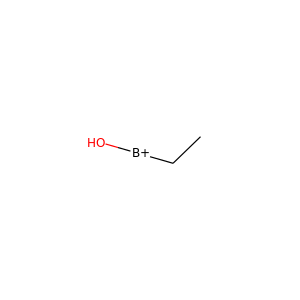

In [296]:
from rdkit.Chem import Draw

Draw.MolToImage(mol)